(1, 1000, 2)


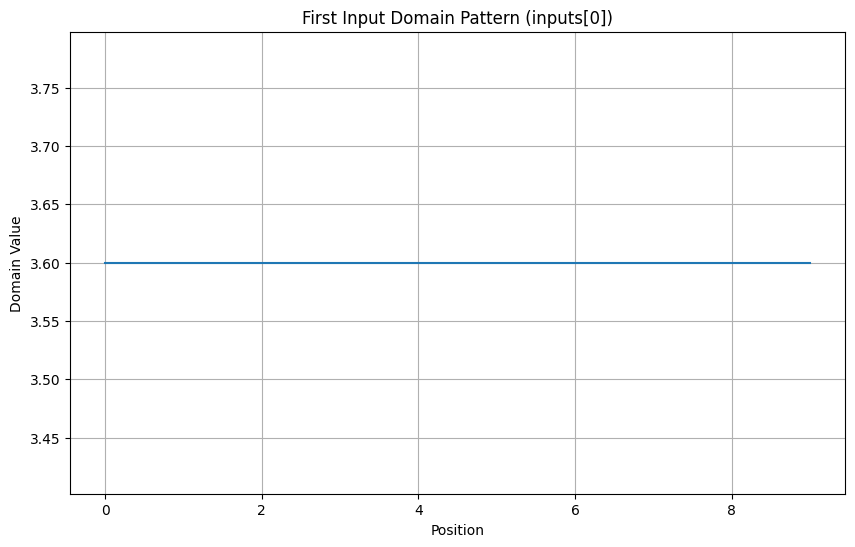

Elapsed time: 0.33 seconds


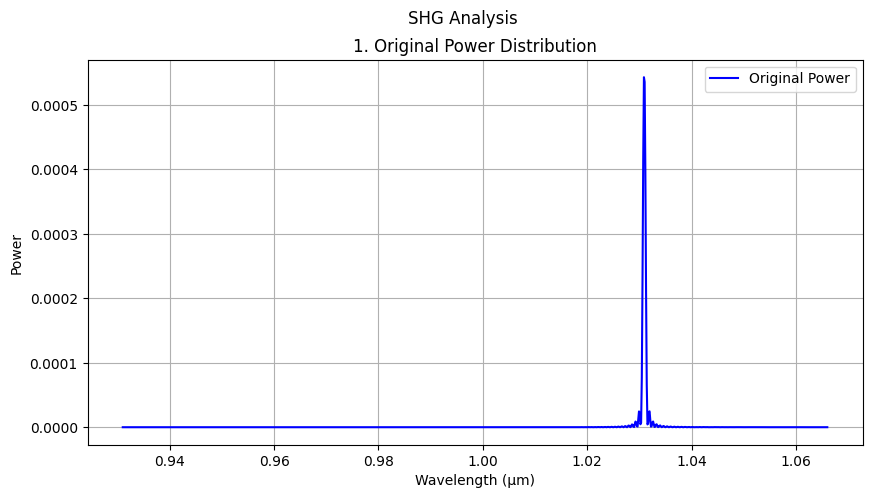

In [11]:
import jax.numpy as jnp
import timeit
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp

num_domains = 10000

# なんか級数展開しやすいドメイン数というのがある気がする
# chirped_grating = pp.chirped(600, [3.6], 1.031E-05, [0.0001])
grating1 = pp.fixed(1000, [3.6], 1.031E-05)
# grating2 = pp.periodical(1000, [7.2], 1.031E-05, 1/5)


def width_fn_apodized(i):
    apodization_factor = jnp.exp(-((i - num_domains/2)
                                 ** 2) / (2 * (num_domains/6)**2))
    base_width = 3.6
    modulation = 0.1 * apodization_factor
    width1 = base_width + modulation
    width2 = base_width - modulation
    return jnp.where(i % 2 == 0, width1, width2)


grating3 = pp.from_width_function(1000, 1.031E-05, width_fn_apodized)
# random_grating = pp.random(1, 300, 1.031E-05, 3.4, 3.6)
grating = grating1

# mesh の細かさが一定でも、対象とする波長範囲が狭くなるとフーリエ変換の成分の数が大幅に減ることには物理的な理由があるのかもしれない
# 指定の波長範囲の変換に寄与するドメインの数が減るからかもしれない
# いつもの chirped の図を書く時の波長範囲は0.931 ~ 1.066
wavelengths = jnp.linspace(0.931, 1.066, 1000).tolist()
delta_wavelength = wavelengths[1] - wavelengths[0]

params = shg.Params(
    grating_dim=grating,
    T_dim=70,
    wavelength_dim=wavelengths,
    fund_power_dim=1,
    sh_power_dim=0,
)

plt.figure(figsize=(10, 6))
print(grating.shape)
plt.plot(grating[0, 100:110, 0])
plt.xlabel('Position')
plt.ylabel('Domain Value')
plt.title('First Input Domain Pattern (inputs[0])')
plt.grid(True)
plt.show()

start = timeit.default_timer()
eff_tensor = mgoslt.analyze(params)
stop = timeit.default_timer()
print(f"Elapsed time: {stop - start:.2f} seconds")
eff_complex = eff_tensor[3, 0, :, 0, 0]

original_power = jnp.abs(eff_complex)**2
fig, (ax_original) = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle("SHG Analysis")

ax_original.plot(wavelengths, original_power,
                 color='blue', label="Original Power")
ax_original.set_xlabel("Wavelength (μm)")
ax_original.set_ylabel("Power")
ax_original.set_title("1. Original Power Distribution")
ax_original.legend()
ax_original.grid(True)